Visualising our Van Rossum loss to check if it's working as expected

In [ ]:
from optimisation.loss_functions import VanRossumLoss
import matplotlib.pyplot as plt
import torch

In [13]:
# make random spiketrain
t = 1.0  # seconds
dt = 0.001  # seconds
r = 5  # Hz
spiketrain = (torch.rand(int(t / dt)) < r * dt).float()
spiketrain = spiketrain[None, :, None]
empty_spiketrain = torch.zeros_like(spiketrain)
spiketrain2 = (torch.rand(int(t / dt)) < r * dt).float()
spiketrain2 = spiketrain2[None, :, None]

In [ ]:
vr_loss = VanRossumLoss(tau=0.02, dt=dt, window_size=100, debug=True)

In [15]:
loss, output_smooth, target_smooth = vr_loss(spiketrain, spiketrain2)

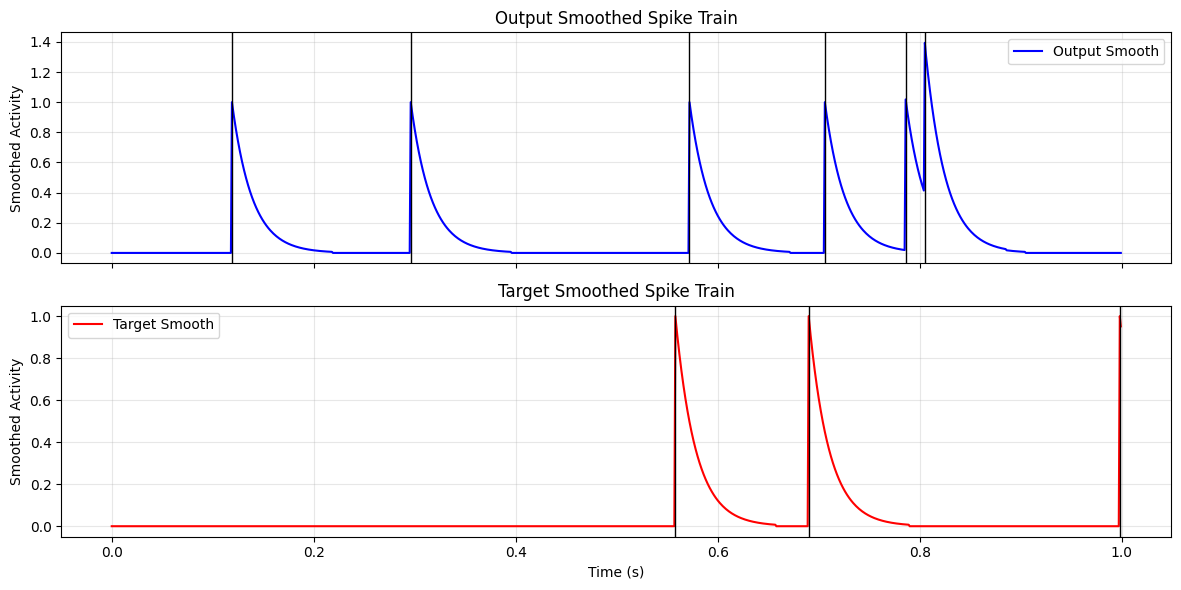

In [20]:
# Prepare data for plotting
time_axis = torch.arange(spiketrain.shape[1]) * dt
spike_indices = torch.where(spiketrain[0, :, 0])[0]
spike_indices2 = torch.where(spiketrain2[0, :, 0])[0]
output_smooth_plot = output_smooth[0, 0, :].detach()
target_smooth_plot = target_smooth[0, 0, :].detach()

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot output smooth with spikes
ax1.plot(
    time_axis, output_smooth_plot, label="Output Smooth", color="blue", linewidth=1.5
)
for spike_idx in spike_indices:
    ax1.axvline(x=spike_idx * dt, color="black", alpha=1.0, linewidth=1.0)
ax1.set_ylabel("Smoothed Activity")
ax1.set_title("Output Smoothed Spike Train")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot target smooth with spikes
ax2.plot(
    time_axis, target_smooth_plot, label="Target Smooth", color="red", linewidth=1.5
)
for spike_idx in spike_indices2:
    ax2.axvline(x=spike_idx * dt, color="black", alpha=1.0, linewidth=1.0)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Smoothed Activity")
ax2.set_title("Target Smoothed Spike Train")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()